## Workshop - Curation module

In this workshop, we will take a look at how to curate the output of a spike-sorting analyses using the `curation` and `qualitymetrics` modules.

The dataset we will be using is a cerebellar cortex recording (cut down to 5 minutes and 26 channels)

In [1]:
import numpy as np
import spikeinterface.core as si
import spikeinterface.curation as scur
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as sqm
import spikeinterface.widgets as sw

In [2]:
recording = si.load_extractor("recording.bin")
sorting = si.load_extractor("ks2_analysis")

print(recording)
print(sorting)

BinaryFolderRecording: 26 channels - 30.0kHz - 1 segments - 9,000,000 samples 
                       300.00s (5.00 minutes) - int16 dtype - 446.32 MiB
NumpyFolderSorting: 52 units - 1 segments - 30.0kHz


Before analyzing our output, we can perform a fast curation:
- Remove any duplicated spikes (spikes happening less than 0.3ms apart)
- Remove excess spikes (kilosort sometimes outputs spikes hapenning out of the recording bounds)
- Remove redundant units (high fraction of shared spikes)

In [3]:
sorting = scur.remove_duplicated_spikes(sorting, censored_period_ms=0.3, method="keep_first_iterative")
sorting = scur.remove_excess_spikes(sorting, recording)
sorting = scur.remove_redundant_units(sorting, align=False, remove_strategy="max_spikes")
sorting

UnitsSelectionSorting: 52 units - 1 segments - 30.0kHz

We still have 52 units (on redundants in this dataset), but probably not all of them are really good!

Let's create a `SortingAnalyzer` to start looking at out data

In [4]:
recording_f = spre.bandpass_filter(recording, freq_min=120, freq_max=8000, filter_order=2, ftype="bessel")

analyzer = si.create_sorting_analyzer(sorting, recording_f, format="memory", sparse=False)
analyzer.compute({
    'noise_levels': {},
    'random_spikes': {'max_spikes_per_unit': 1_000},
    'templates': {'ms_before': 1.5, 'ms_after': 3.5},
    'spike_amplitudes': {},
    'correlograms': {'bin_ms': 0.5}
})

estimate_templates_with_accumulator:   0%|          | 0/300 [00:00<?, ?it/s]

Compute : spike_amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

Let's look at the most basic metric: the average firing rate (in Hz) of our units:

In [5]:
sqm.compute_firing_rates(analyzer)

{0: 11.756666666666666,
 1: 8.663333333333334,
 2: 10.083333333333334,
 3: 1.1433333333333333,
 4: 8.596666666666666,
 5: 0.7366666666666667,
 6: 0.35333333333333333,
 7: 9.653333333333334,
 8: 0.056666666666666664,
 9: 20.69333333333333,
 10: 12.796666666666667,
 11: 1.0533333333333332,
 12: 37.053333333333335,
 13: 27.203333333333333,
 14: 24.786666666666665,
 15: 29.236666666666668,
 16: 20.196666666666665,
 17: 21.466666666666665,
 18: 18.023333333333333,
 19: 14.413333333333334,
 20: 0.4266666666666667,
 21: 6.756666666666667,
 22: 14.89,
 23: 13.603333333333333,
 24: 16.33,
 25: 12.146666666666667,
 26: 10.21,
 27: 12.283333333333333,
 28: 15.88,
 29: 15.686666666666667,
 30: 11.643333333333333,
 31: 18.876666666666665,
 32: 0.14666666666666667,
 33: 17.053333333333335,
 34: 1.2566666666666666,
 35: 19.28,
 36: 16.30666666666667,
 37: 9.073333333333334,
 38: 37.623333333333335,
 39: 1.5866666666666667,
 40: 114.08666666666667,
 41: 136.71333333333334,
 42: 17.173333333333332,
 43

We can see that the firing rate varies a lot, with some units being below 0.5 Hz (probably bad units), and some units above 100 Hz (not uncommon for Purkinje cells simple spikes).

We can compute all of SpikeInterface quality metrics with the following command:

In [6]:
quality_metrics = sqm.compute_quality_metrics(analyzer)
quality_metrics.head()

/export/home1/users/nsr/wyngaard/dev/spikeinterface/spikeinterface/src/spikeinterface/qualitymetrics/misc_metrics.py:880: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


,amplitude_cutoff,amplitude_cv_median,amplitude_cv_range,amplitude_median,firing_range,firing_rate,isi_violations_ratio,isi_violations_count,num_spikes,presence_ratio,rp_contamination,rp_violations,sd_ratio,sliding_rp_violation,snr,sync_spike_2,sync_spike_4,sync_spike_8
0,0.000323,0.616395,0.208433,-73.320000,5.21,11.756667,0.353705,44,3527,1.0,0.605120,35,1.186130,0.210,2.131218,0.035157,0.000000,0.0
1,0.000714,0.452644,0.145765,-109.590004,7.41,8.663333,0.236869,16,2599,1.0,0.254432,10,1.535832,0.070,3.714353,0.058869,0.000000,0.0
2,0.000406,1.022444,0.572497,-47.189999,6.23,10.083333,0.393416,36,3025,1.0,0.615814,26,1.565250,0.120,1.702701,0.037355,0.000000,0.0
3,NaN,NaN,NaN,-277.484985,0.80,1.143333,0.000000,0,343,1.0,0.000000,0,1.152161,0.295,9.148531,0.026239,0.000000,0.0
4,0.000852,0.648870,0.255289,-71.175003,5.66,8.596667,0.405939,27,2579,1.0,0.621824,19,1.225778,0.245,2.146683,0.036836,0.000388,0.0


As we can see, there are a lot of metrics (some containing redundant information).
For demonstration purposes, we will focus on 4 of those metrics (which I use all the time):
- `firing_rate`: The mean firing rate (in Hz). The total number of spikes divided by the duration of the recording. This helps a lot for classifying units (knowing the cell type) and to find aberrant units.
- `SNR`: The Signal-to-Noise Ratio (amplitude of the spike divided by the noise level). A low SNR (< 3) is usually problematic.
- `rp_contamination`: Contamination (i.e. $FP \over TP+FP$) estimation by looking at the refractory period violations. Makes the hypothesis that the contaminant spikes happen at random.
- `sd_ratio`: The ratio between the standard deviation of spike amplitudes and the noise level. Under the assumption that all spikes have the same shape, this ratio should be $1.0$. Several safeguards are included to remove effects of drift, bursting ...

In [7]:
quality_metrics = quality_metrics[["firing_rate", "snr", "rp_contamination", "sd_ratio"]]
quality_metrics

,firing_rate,snr,rp_contamination,sd_ratio
0,11.756667,2.131218,0.605120,1.186130
1,8.663333,3.714353,0.254432,1.535832
2,10.083333,1.702701,0.615814,1.565250
3,1.143333,9.148531,0.000000,1.152161
4,8.596667,2.146683,0.621824,1.225778
5,0.736667,1.658713,1.000000,2.645382
6,0.353333,2.942544,1.000000,2.514762
7,9.653333,2.541169,1.000000,1.076553
8,0.056667,2.548325,0.000000,1.339468
9,20.693333,3.406653,0.056061,1.101079


From having looked at the dataset extensively, I know what units are very good:

In [8]:
good_unit_ids = np.array([3, 13, 19, 34, 39, 40, 41], dtype=np.int32)
ok_unit_ids = np.array([11, 18, 22, 51], dtype=np.int32)

In [9]:
quality_metrics.loc[good_unit_ids]

,firing_rate,snr,rp_contamination,sd_ratio
3,1.143333,9.148531,0.000000,1.152161
13,27.203333,3.779149,0.002255,1.059246
19,14.413333,6.601321,0.000000,1.279718
34,1.256667,4.820152,0.000000,1.261320
39,1.586667,5.655484,0.000000,1.203222
40,114.086667,2.223399,0.004749,1.039734
41,136.713333,6.818094,0.002768,1.046981


In [10]:
quality_metrics.loc[ok_unit_ids]

,firing_rate,snr,rp_contamination,sd_ratio
11,1.053333,6.331009,0.000000,1.072506
18,18.023333,4.249267,0.074614,1.266944
22,14.890000,4.276668,0.137206,1.294446
51,1.263333,3.492503,0.000000,1.002276


Looking at the metrics on the good units, we can create rules to only keep units that are of sufficient quality. For example:
- A `firing_rate` greater than 1.0 Hz
- A `snr` greater than 2.0
- A `rp_contamination` below 20%
- A `sd_ratio` below 1.5

In [11]:
good_units_mask = (quality_metrics['firing_rate'] > 1.0) & \
             (quality_metrics['snr'] > 1.1) & \
             (quality_metrics['rp_contamination'] < 0.2) & \
             (quality_metrics['sd_ratio'] < 1.5)

print(sorting.unit_ids[good_units_mask])
good_sorting = sorting.select_units(sorting.unit_ids[good_units_mask])

[ 3  9 11 13 14 15 17 18 19 22 27 28 31 33 34 35 38 39 40 41 43 46 47 48
 49 51]


In [12]:
good_sorting

UnitsSelectionSorting: 26 units - 1 segments - 30.0kHz

We removed half of the units in the Kilosort output! (we started with 52).

The metrics and thresholds used will, of course, depend on the recording type, and need to be tuned.
After tuning, we can have a powerful automated curation, that is not perfect, but removes a lot of the obviously garbage units.

The `curation` module also offers a method to find split units, that you can inspect and decide whether you want to merge them.

In [13]:
pairs = scur.get_potential_auto_merge(analyzer)
pairs

[(28, 31)]

We can see that the merge function found a pair that is potentially a good merge.

We can check it by plotting the correlograms and templates:

/export/home1/users/nsr/wyngaard/dev/spikeinterface/spikeinterface/src/spikeinterface/widgets/unit_waveforms.py:151: UserWarning: templates_percentile_shading can only be used if the 'waveforms' extension is available. Settimg templates_percentile_shading to None.
  warn(


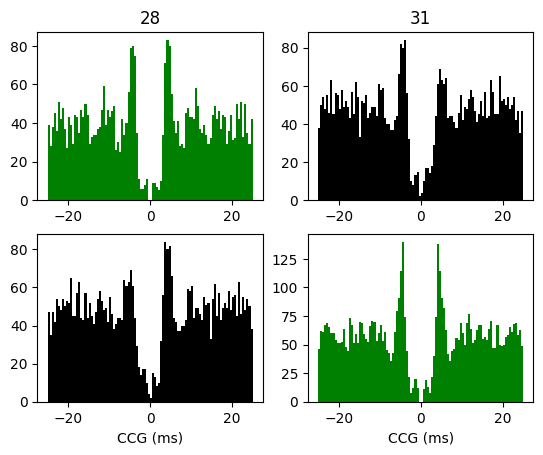

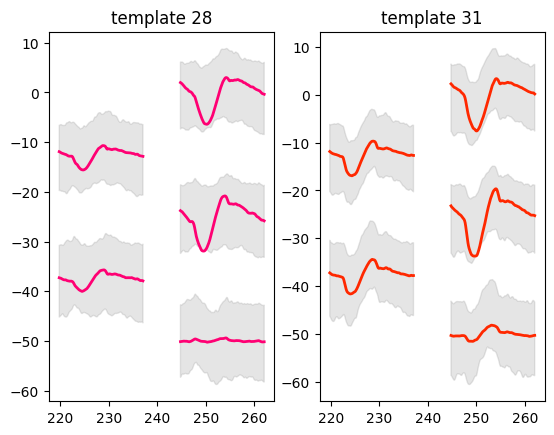

In [14]:
for pair in pairs:
    sw.plot_crosscorrelograms(analyzer, unit_ids=pair, min_similarity_for_correlograms=None)
    sw.plot_unit_templates(analyzer, unit_ids=pair, channel_ids=np.arange(13, 18))

Indeed, the correlograms and templates seem to match!

We can thus create a script to merge the units together:

In [15]:
curation_sorting = scur.CurationSorting(good_sorting)
curation_sorting.merge(pairs)

In [16]:
curation_sorting.sorting

MergeUnitsSorting: 25 units - 1 segments - 30.0kHz